In [2]:
import hnswlib
import numpy as np
import pickle
import numpy as np 
from matplotlib import pyplot as plt 

In [3]:
dim = 1
num_elements = 1000

In [4]:
def create_100_data_points_around(num):
    data = [[x] for x in range(num-50, num+50)]
    labels = [x for x in range(num-50, num+50)]
    return data, labels

In [5]:

# Declaring index
p = hnswlib.Index(space = 'l2', dim = dim) # possible options are l2, cosine or ip

# Initializing index - the maximum number of elements should be known beforehand
p.init_index(max_elements = num_elements, ef_construction = 3, M = 3)


In [6]:
# p.add_items(*create_100_data_points_around(100))
# p.add_items(*create_100_data_points_around(1000))
# p.add_items(*create_100_data_points_around(300))
# p.add_items(*create_100_data_points_around(800))
# p.add_items(*create_100_data_points_around(400))
# p.add_items(*create_100_data_points_around(700))
# p.add_items([[500], [501], [599], [600]], [500, 501, 599, 600])

p.add_items(*create_100_data_points_around(50))
p.add_items(*create_100_data_points_around(250))
p.add_items([[110], [190]], [110, 190])
p.add_items([[120], [180]], [120, 180])
p.add_items([[130], [170]], [130, 170])
p.add_items([[140], [160]], [140, 160])
p.add_items([[145], [155]], [145, 155])


In [7]:
labels, distances = p.knn_query([145], k = 10)

In [8]:
print(labels)

[[145 140 130 120 110  99  98  97  96  95]]


In [9]:
print(distances)

[[   0.   25.  225.  625. 1225. 2116. 2209. 2304. 2401. 2500.]]


## Test on MNIST dataset
Download MNIST dataset with this url:
http://ann-benchmarks.com/mnist-784-euclidean.hdf5

In [10]:
import h5py

In [13]:
f = h5py.File('mnist-784-euclidean.hdf5', 'r')
distances = f['distances']
neighbors = f['neighbors']
test = f['test']
train = f['train']

In [14]:
all_data = np.concatenate((train, test))

In [29]:
## retrieve top k index
def kNN(data, query, k):
    distance = np.sum((data-query)**2, axis=1)
    dist_ind = distance.argsort()[:k]
    return dist_ind

In [20]:
def get_recall(retrieved, ground_truth):
    assert(retrieved.shape == ground_truth.shape)
    return np.sum(np.isin(retrieved, ground_truth))/ground_truth.shape[0]

## Experiment to log recall while adding datapoints
After adding `step` data points, we query on the first `test_k` data points on the new updated index.

In [58]:
def add_data_experiment(init_data, input_data, step, test_k, k):

    dim = 784
    num_elements = 70000
    init_size = init_data.shape[0]

    # Declaring index
    hnsw = hnswlib.Index(space = 'l2', dim = dim)
    
    # Initializing index - the maximum number of elements should be known beforehand
    hnsw.init_index(max_elements = num_elements, ef_construction = 20, M = 5)

    # add init_data
    hnsw.add_items(init_data, np.arange(0, init_size))

    recall_results = []
    # assume hnsw is already initialized and contains an initial distribution
    for x in range(0, input_data.shape[0], step):
        print("Processing:", x)
        # add "step" data points and test on test_k random_data_points
        hnsw.add_items(input_data[x:x+step], np.arange(x+init_size, x+step+init_size))
        step_result = []

        for i in range(test_k):
            # random_test = np.random.choice(256, 784)
            # ground_truth = kNN(np.concatenate((init_data, input_data[:x+step])), random_test, k)
            # retrieved, _ = p.knn_query(random_test, k = k)
            ground_truth = kNN(np.concatenate((init_data, input_data[:x+step])), input_data[x+i], k)
            retrieved, _ = hnsw.knn_query(input_data[x+i], k = k)
            recall = get_recall(retrieved[0], ground_truth)
            step_result.append(recall)
            print(retrieved[0], ground_truth, recall)
        recall_results.append(step_result)
    return recall_results

In [59]:
cut = 20000
recall_results = add_data_experiment(all_data[:cut], all_data[cut:], 100, 5, 10)

Processing: 0
[20000  7458 13606  7674  4770 19006  5804 18907 11474  8916] [20000  7458 13606 18494  7674  4770 16545  9579 19006  5804] 0.7
[20021 16197  7899 11365  7900  8816 10705 16003  7802  7928] [20001  9817 20021 11419  2362  3245  4371 15597 10571 18359] 0.1
[20002 12145  8465 12319  2967  4130  2844  8734   825 15326] [20002 12145  8465 12319  2967  4130  2844 12297 12187 19274] 0.7
[20003 18626 16036 12764 12712 17756 10176 18316  4194  2196] [20003 18626 16036 12764 12712 17756 10176 18316 14912  4194] 0.9
[20004 17198  4701  3075   681  3491   634 18356 15282 12060] [20004 17198  4701  3075   681  3491   634 18356 15282 12060] 1.0
Processing: 100
[20100 12332 17370 11998  1927  7348 18740   174  7271 11714] [20100 12332 17370 11998 16910  1927  7348 18740   174  1356] 0.8
[20101  9908 17815 10785 20163 17711 18121 11567 17715  3018] [20101  9908 17815 10785 20163 17711 18121 11567 17715  3018] 1.0
[20102 16438  4088 12640   599  4095 13302 13874 14568  9094] [20102 16438

In [60]:
avg = np.average(recall_results, axis=1)
print(avg.shape)

(500,)


In [61]:
def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

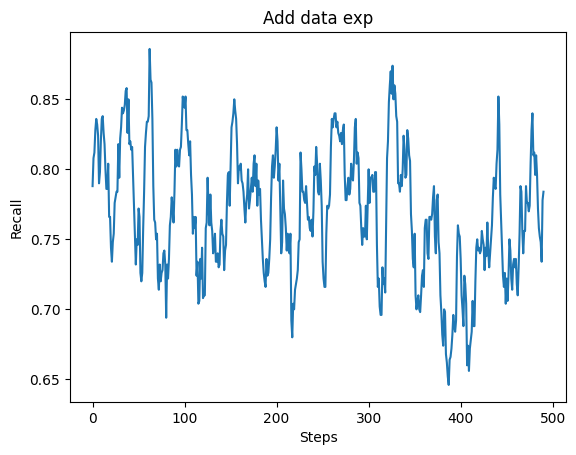

In [66]:
plt.title("Add data exp") 
plt.xlabel("Steps") 
plt.ylabel("Recall") 
plt.plot(moving_average(avg, 10)) 
plt.show()

## Calculate Recall using all data (as if reindexing using all data)

In [51]:
dim = 784
num_elements = 70000
k = 5
init_size = all_data.shape[0]

# Declaring index
hnsw = hnswlib.Index(space = 'l2', dim = dim)

# Initializing index - the maximum number of elements should be known beforehand
hnsw.init_index(max_elements = num_elements, ef_construction = 20, M = 5)

# add init_data
hnsw.add_items(all_data, np.arange(0, init_size))

step_result = []
x=49900

for i in range(5):
    ground_truth = kNN(all_data, all_data[x+i], k)
    retrieved, _ = hnsw.knn_query(all_data[x+i], k = k)
    recall = get_recall(retrieved[0], ground_truth)
    step_result.append(recall)
    print(retrieved[0], ground_truth, recall)
print(step_result)

[49900 31831 64700 21978  8674] [49900 31831 64700 21978  8674] 1.0
[49901  7578 45187  7521 49903] [49901 69923 50773 29081  7578] 0.4
[49902 34654 32494 33560 10876] [49902 34654 32494 33560 10876] 1.0
[49903 13085 49901 69133 49803] [49903 13085 29081 49901 69133] 0.8
[49904 24916 47204 53466 62038] [49904 24916 47204 53466 62038] 1.0
[1.0, 0.4, 1.0, 0.8, 1.0]


## Experiment to log recall while adding and deleting datapoints
After adding `step` number of data points, we delete the earliest `step` number of data points.
This simulates a scenario where we want to keep the vector datdabase to a constant size.

We claim that this performance degradation happens because there is an embedding drift.

In [76]:
def add_and_delete_data_experiment(init_data, input_data, step, test_k, k):

    dim = 784
    num_elements = 70000
    init_size = init_data.shape[0]

    # Declaring index
    hnsw = hnswlib.Index(space = 'l2', dim = dim)
    
    # Initializing index - the maximum number of elements should be known beforehand
    hnsw.init_index(max_elements = num_elements, ef_construction = 20, M = 5)

    # add init_data
    hnsw.add_items(init_data, np.arange(0, init_size))

    recall_results = []
    # assume hnsw is already initialized and contains an initial distribution
    for x in range(0, input_data.shape[0], step):
        print("Processing:", x)
        # add "step" data points and test on test_k random_data_points
        hnsw.add_items(input_data[x:x+step], np.arange(x+init_size, x+step+init_size))
        for i in range(step):
            hnsw.mark_deleted(x+i)
        print("Add index from", x+init_size, " to", x+step+init_size)
        print("Delete index from", x, " to", x+step)
        step_result = []

        for i in range(test_k):
            # random_test = np.random.choice(256, 784)
            # ground_truth = kNN(np.concatenate((init_data, input_data[:x+step])), random_test, k)
            # retrieved, _ = p.knn_query(random_test, k = k)
            ground_truth = kNN(np.concatenate((init_data, input_data[:x+step])), input_data[x+i], k)
            retrieved, _ = hnsw.knn_query(input_data[x+i], k = k)
            recall = get_recall(retrieved[0], ground_truth)
            step_result.append(recall)
            print(retrieved[0], ground_truth, recall)
        recall_results.append(step_result)
    return recall_results

In [77]:
cut = 20000
add_and_delete_recall_results = add_and_delete_data_experiment(all_data[:cut], all_data[cut:], 100, 5, 10)

Processing: 0
Add index from 20000  to 20100
Delete index from 0  to 100
[20000  7458 18494  7674  4770 19006  5804 18907 11474  8916] [20000  7458 13606 18494  7674  4770 16545  9579 19006  5804] 0.7
[20001 11419  2362  4371 15597 10571 18359 18431 13497 10963] [20001  9817 20021 11419  2362  3245  4371 15597 10571 18359] 0.7
[20002 12145  8465 12319  2967  4130  2844  8734   825 15326] [20002 12145  8465 12319  2967  4130  2844 12297 12187 19274] 0.7
[20003 18626 16036 12764 12712 17756 10176 18316  4194 16272] [20003 18626 16036 12764 12712 17756 10176 18316 14912  4194] 0.9
[20004 17198  4701  3075   681  3491   634 18356 15282 12060] [20004 17198  4701  3075   681  3491   634 18356 15282 12060] 1.0
Processing: 100
Add index from 20100  to 20200
Delete index from 100  to 200
[20100 12332 17370 16910  1927  7348  7271 11714 16642  1262] [20100 12332 17370 11998 16910  1927  7348 18740   174  1356] 0.6
[20101  9908 17815 10785 20163 17711 18121 11567 17715  3018] [20101  9908 17815 1

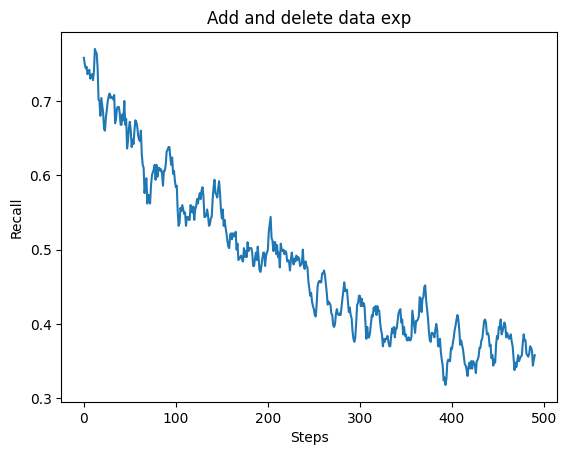

In [78]:
avg = np.average(add_and_delete_recall_results, axis=1)
plt.title("Add and delete data exp") 
plt.xlabel("Steps") 
plt.ylabel("Recall") 
plt.plot(moving_average(avg, 10)) 
plt.show()